In [2]:
# importing all the libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd
import matplotlib as mpl

import os
cwd = os.getcwd()

%run ../functions_MCMC

In [3]:
# define variables
data_seed = 1223
burnin = 1000 #1k
n_after_burnin = 10000 #10k
delta_t = 0.3

#T=60 gives 200 delta_y
T = 60
n_it = 1
seeds_list = [1229, 1231, 1237, 1249, 1259, 1277, 1279, 1283, 1289, 1291]
n_sim = 100

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5])
log_Lambda = np.log(Lambda)
P = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma = 50.0
sigma_max = np.max(np.abs(V))*delta_t/10.0
n = Lambda.shape[0]
n_param = 5

parameter_names = ['v1', 'v2', 'loglambda1', 'loglambda2', 'sigma']
parameter_names_tex = [r'$v_1$', r'$v_2$', r'log($\lambda_1$)',
                       r'log($\lambda_2$)', r'$\sigma$']

#choose initial covariance matrix for resampling
init_cov_matrix = np.diag(np.array([0.1, 0.1, 0.0001, 0.0001, 0.01]))

correlated = False
up_to_switches = 1
track = False

plots = False
save = True
all_plots = False
plot_posteriors_grid = False
save_pearsons_correlations = False
plot_fit = False
plot_fit_median = False

theta_true = list(V) + list(log_Lambda) + [sigma] #not including values for P for 2x2

In [4]:
#THIS STILL NEEDS TO BE MODIFIED FOR SEVERAL CASES
def get_parameters(theta):
    V = np.zeros(2)
    V[0] = 1.0*theta[0]
    V[1] = 1.0*theta[1]
    Lambda = 1.0*np.exp(np.array(theta[2:4]))
    P = np.zeros((2,2))
    P[0,1] = 1.0
    P[1,0] = 1.0
    sigma = 1.0*theta[-1]
    
    return V, Lambda, P, sigma

In [5]:
times_NOTtrack_list = [77, 92, 97]
times_track_list = [2244, 4453, 8539]
#note that these are rounded to integer from the output files ending in _1.out
#for each case (in the folder OUTPUTS)

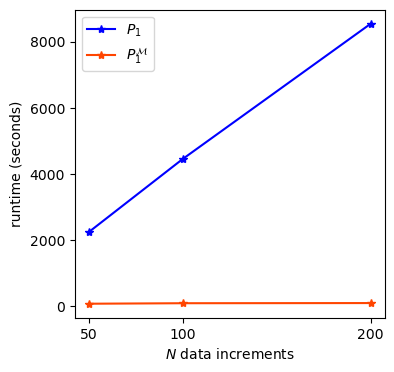

In [6]:
#Figure S5 panel F
#for seed 0
N_list = [50,100,200]
plt.figure(figsize=(4,4))
plt.plot(N_list, times_track_list, '-*', color='blue', label=r'$P_1$')
plt.plot(N_list, times_NOTtrack_list, '-*', color='orangered', label=r'$P_1^{\mathcal{M}}$')
plt.xticks(N_list, N_list)
plt.legend()
plt.xlabel(r'$N$ data increments')
plt.ylabel(r'runtime (seconds)')
plt.savefig("NOTtrack_vs_track_runtime_varying_N.png", format="png", dpi=1200,
            bbox_inches="tight")
plt.show()

In [ ]:
#importing data (ratesx1 = datax1 and it's the same as Figure S4)
theta_all = {'datadiv4':[[] for _ in range(100)],
             'datadiv2':[[] for _ in range(100)],
             'ratesx1':[[] for _ in range(100)]}
log_pi = {'datadiv4':[None for _ in range(100)],
          'datadiv2':[None for _ in range(100)],
          'ratesx1':[None for _ in range(100)]}
theta_best = {'datadiv4':[None for _ in range(100)],
              'datadiv2':[None for _ in range(100)],
              'ratesx1':[None for _ in range(100)]}

list_1 = ['datadiv4', 'datadiv2', 'ratesx1']

theta_all_NOTtrack = {'datadiv4':[[] for _ in range(100)],
                      'datadiv2':[[] for _ in range(100)],
                      'ratesx1':[[] for _ in range(100)]}
log_pi_NOTtrack = {'datadiv4':[None for _ in range(100)],
                   'datadiv2':[None for _ in range(100)],
                   'ratesx1':[None for _ in range(100)]}
theta_best_NOTtrack = {'datadiv4':[None for _ in range(100)],
                       'datadiv2':[None for _ in range(100)],
                       'ratesx1':[None for _ in range(100)]}

list_1 = ['datadiv4', 'datadiv2', 'ratesx1']

list_2 = [50, 100, 200]

for el in list_1:
    print("Importing theta - folder", el, "seed")
    for seed in range(100):
        print(seed)
        for param in parameter_names:
            theta_all[el][seed] += [np.array(pd.read_csv("RESULTS_2_"+el+"/MCMC, seed "+str(seed)+", parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
            theta_all_NOTtrack[el][seed] += [np.array(pd.read_csv("RESULTS_2_"+el+"_NOTtrack/MCMC, seed "+str(seed)+", parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
        theta_all[el][seed] = np.array(theta_all[el][seed])
        theta_all_NOTtrack[el][seed] = np.array(theta_all_NOTtrack[el][seed])

        log_pi[el][seed] = np.array(pd.read_csv("RESULTS_2_"+el+"/MCMC, seed "+str(seed)+", log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
        theta_best[el][seed] = theta_all[el][seed][:, np.argmax(log_pi[el][seed])]

        log_pi_NOTtrack[el][seed] = np.array(pd.read_csv("RESULTS_2_"+el+"_NOTtrack/MCMC, seed "+str(seed)+", log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
        theta_best_NOTtrack[el][seed] = theta_all_NOTtrack[el][seed][:, np.argmax(log_pi_NOTtrack[el][seed])]

In [ ]:
stds_corr = {50:[None for _ in range(100)],
             100:[None for _ in range(100)],
             200:[None for _ in range(100)]}

stds_corr_NOTtrack = {50:[None for _ in range(100)],
                      100:[None for _ in range(100)],
                      200:[None for _ in range(100)]}

for i in range(3):
    for seed in range(100):
        stds_corr[list_2[i]][seed] = np.std(theta_all[list_1[i]][seed], axis=1)
        stds_corr_NOTtrack[list_2[i]][seed] = np.std(theta_all_NOTtrack[list_1[i]][seed], axis=1)
    stds_corr[list_2[i]] = np.array(stds_corr[list_2[i]]).T
    stds_corr_NOTtrack[list_2[i]] = np.array(stds_corr_NOTtrack[list_2[i]]).T

In [ ]:
stds_medians_corr = np.array([np.median(stds_corr[i], axis=1) for i in [50,100,200]])
stds_medians_corr_NOTtrack = np.array([np.median(stds_corr_NOTtrack[i], axis=1) for i in [50,100,200]])

In [ ]:
one_over_sqrt_N = 1 / np.sqrt(np.array([50,100,200]))

In [ ]:
#Figure S5 panels A-E
colors_track = mpl.colormaps['Blues'](np.linspace(0, 1, 5))[3:0:-1]
colors_NOTtrack = mpl.colormaps['Oranges'](np.linspace(0, 1, 5))[3:0:-1]
for j in [0,1,2,3,4]:
    fig, ax = plt.subplots(1,2, figsize=(7,3.5), sharey=True, sharex=True)
    
    ax[0].axhline(0.0, linestyle='--', color='gray')
    ax[1].axhline(0.0, linestyle='--', color='gray')
    
    lin_f = np.polyfit(one_over_sqrt_N, stds_medians_corr[:, j], 1)
    linsp = np.linspace(one_over_sqrt_N[0], one_over_sqrt_N[2])
    y = np.polyval(lin_f, linsp)
    print(lin_f)
    ax[0].plot((1/linsp)**2, y, color='black', label=r'$S=m\cdot \frac{1}{\sqrt{N}} + q$')
        
    bplot = ax[0].boxplot([stds_corr[i][j,:] for i in [50,100,200]],
                           positions=[50,100,200], patch_artist=True, vert=True, widths=15)
    for patch, patch2, color in zip(bplot['boxes'], bplot['medians'], colors_track):
        patch.set_facecolor(color)
        patch2.set_color('black')
    
    lin_f = np.polyfit(one_over_sqrt_N, stds_medians_corr_NOTtrack[:, j], 1)
    linsp = np.linspace(one_over_sqrt_N[0], one_over_sqrt_N[2])
    y = np.polyval(lin_f, linsp)
    print(lin_f)
    ax[1].plot((1/linsp)**2, y, color='black', label=r'$S=m\cdot \frac{1}{\sqrt{N}} + q$')
        
    bplot = ax[1].boxplot([stds_corr_NOTtrack[i][j,:] for i in [50,100,200]],
                           positions=[50,100,200], patch_artist=True, vert=True, widths=15)
    for patch, patch2, color in zip(bplot['boxes'], bplot['medians'], colors_NOTtrack):
        patch.set_facecolor(color)
        patch2.set_color('black')
        
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylabel("S := std("+parameter_names_tex[j]+")")
    ax[0].set_xlabel(r'$N$ data increments')
    ax[1].set_xlabel(r'$N$ data increments')
    ax[0].set_title(r'$P_1$')
    ax[1].set_title(r'$P_1^{\mathcal{M}}$')
    ax[0].set_xticks(ticks=[50,100,200], labels=[50,100,200])
    ax[1].set_xticks(ticks=[50,100,200], labels=[50,100,200])
    plt.subplots_adjust(wspace=0.1)
    plt.savefig("NOTtrack_vs_track_stds_interp_"+parameter_names[j]+".png", format="png", dpi=1200,
                bbox_inches="tight")
    plt.show()